<a href="https://colab.research.google.com/github/Draciger/DracPyTorch/blob/main/MandatoryAssigment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing libraries and looking at the data

In [125]:
# Importing different libraries
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [80]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [81]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
    target_transform=None
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
    target_transform=None
)

In [82]:
len(train_data), len(test_data)

(60000, 10000)

In [83]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [84]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

### Preparing DataLoader

In [85]:
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             shuffle=False)

### Building a Simple Feedforward Neural Network - Model MLP

In [112]:
flatten_model = nn.Flatten()

class ModelMLP(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.Linear(in_features=hidden_units,
                      out_features=output_shape)
        )

    def forward(self, x):
      return self.layer_stack(x)

In [113]:
torch.manual_seed(42)

model_MLP = ModelMLP(input_shape=784,
                           hidden_units=10,
                           output_shape=10)

model_MLP

ModelMLP(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [114]:
# Accuracy Metric
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer function
optimizer = torch.optim.SGD(params=model_MLP.parameters(),
                              lr=0.1)

In [115]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

### Making a training loop and training a model on the batches of data

In [116]:
from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_start = timer()
epochs = 3

for epochs in tqdm(range(epochs)):
  print(f"Epoch: {epochs}\n------")
  train_loss = 0
  for batch, (X,y) in enumerate(train_dataloader):
    model_MLP.train()
    y_pred = model_MLP(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)}samples.")

  train_loss /= len(train_dataloader)

  test_loss, test_acc = 0,0
  model_MLP.eval()
  with torch.inference_mode():
    for X_test,y_test in test_dataloader:
      test_pred = model_MLP(X_test)

      test_loss += loss_fn(test_pred, y_test)

      test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

    test_loss /= len(test_data)

    test_acc /= len(test_dataloader)

  print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

  train_time_end_model_MLP = timer()
  total_train_time_model_MLP = print_train_time(start=train_time_start,
                                            end=train_time_end_model_MLP,
                                            device=str(next(model_MLP.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Looked at 0/60000samples.
Looked at 12800/60000samples.
Looked at 25600/60000samples.
Looked at 38400/60000samples.
Looked at 51200/60000samples.

Train loss: 0.4051 | Test loss: 0.0092 | Test acc: 91.6733
Train time on cpu: 12.472 seconds
Epoch: 1
------
Looked at 0/60000samples.
Looked at 12800/60000samples.
Looked at 25600/60000samples.
Looked at 38400/60000samples.
Looked at 51200/60000samples.

Train loss: 0.3084 | Test loss: 0.0090 | Test acc: 91.9529
Train time on cpu: 28.142 seconds
Epoch: 2
------
Looked at 0/60000samples.
Looked at 12800/60000samples.
Looked at 25600/60000samples.
Looked at 38400/60000samples.
Looked at 51200/60000samples.

Train loss: 0.2960 | Test loss: 0.0090 | Test acc: 91.8930
Train time on cpu: 40.040 seconds


In [117]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  loss, acc = 0,0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      y_pred = model(X)

      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y,
                         y_pred=y_pred.argmax(dim=1))

    loss /= len(data_loader)
    acc /= len(data_loader)

    return{"model_name": model.__class__.__name__,
           "model_loss": loss.item(),
           "model_acc": acc}

model_MLP_results = eval_model(model=model_MLP,
                             data_loader=test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn=accuracy_fn)
model_MLP_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'ModelMLP',
 'model_loss': 0.28626734018325806,
 'model_acc': 91.8929712460064}

### Model CNN - Building a Convolutional Neural Network

In [92]:
class ModelCNN(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape,
                out_channels = hidden_units,
                kernel_size = 3,
                stride = 1,
                padding = 1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=output_shape)
    )

  def forward(self,x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

In [93]:
torch.manual_seed(42)
model_CNN = ModelCNN(input_shape=1,
                     hidden_units=10,
                     output_shape=10)
model_CNN

ModelCNN(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

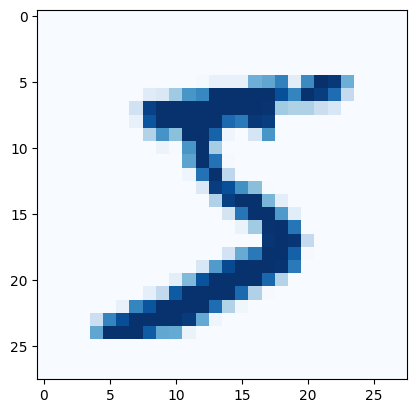

In [94]:
plt.imshow(image.squeeze(), cmap="Blues")

In [95]:
# Accuracy Metric
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer function
optimizer = torch.optim.SGD(params=model_CNN.parameters(),
                              lr=0.1)

In [98]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):

  train_loss, train_acc = 0,0
  model.train()

  for batch, (X,y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1))

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

In [100]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  test_loss, test_acc = 0,0

  model.eval()


  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)

      test_pred = model(X)

      test_loss += loss_fn(test_pred,y)
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

In [101]:
torch.manual_seed(42)

from timeit import default_timer as timer
train_time_start_model_CNN = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n------")
  train_step(model=model_CNN,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model_CNN,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

  train_time_end_model_CNN = timer()
  total_train_time_model_CNN = print_train_time(start=train_time_start_model_CNN,
                                              end=train_time_end_model_CNN,
                                              device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Train loss: 0.07404 | Train acc: 97.72%
Test loss: 0.05522 | Test acc: 98.28%
Train time on cpu: 70.837 seconds
Epoch: 1
------
Train loss: 0.05643 | Train acc: 98.20%
Test loss: 0.04776 | Test acc: 98.53%
Train time on cpu: 152.305 seconds
Epoch: 2
------
Train loss: 0.04721 | Train acc: 98.48%
Test loss: 0.04814 | Test acc: 98.35%
Train time on cpu: 226.715 seconds


In [104]:
model_CNN_results = eval_model(model=model_CNN,
                             data_loader=test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn=accuracy_fn)
model_CNN_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'ModelCNN',
 'model_loss': 0.04814479500055313,
 'model_acc': 98.3526357827476}

In [134]:
compare_results["training_time"]=[total_train_time_model_MLP,
                                  total_train_time_model_CNN]
compare_results

,model_name,model_loss,model_acc,training_time
0,ModelMLP,0.286267,91.892971,40.040013
1,ModelCNN,0.048145,98.352636,226.715075


In [162]:
def plot_confmat(model,
                 dataloader,
                 class_names,
                 device,
                 title="Confusion Matrix"):
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device).eval()

    y_true, y_pred = [], []
    with torch.inference_mode():
        for X, y in dataloader:
            X = X.to(device)
            logits = model(X)
            pred = logits.argmax(1).cpu().numpy()
            y_pred.append(pred)
            y_true.append(y.numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
    disp.plot(xticks_rotation=45, cmap="Blues")
    plt.title(title)
    plt.tight_layout()
    plt.show()


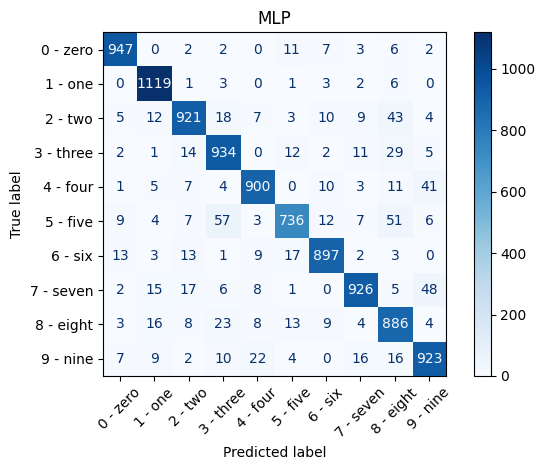

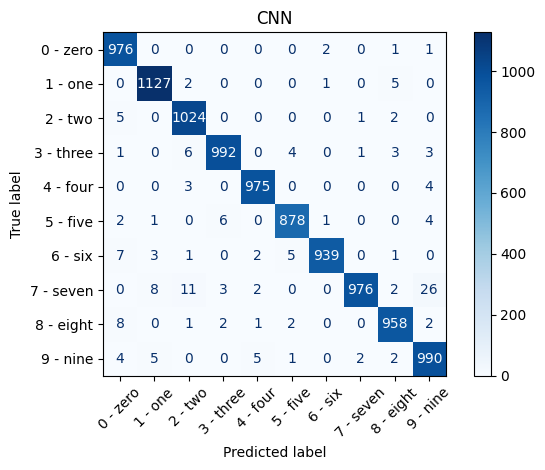

In [161]:
plot_confmat(model_MLP, test_dataloader, class_names, device, title="MLP Confusion Matrix")
plot_confmat(model_CNN, test_dataloader, class_names, device, title="CNN Confusion Matrix")